# Projet 5 - Segmentez des clients d'un site e-commerce - exploration de différents modèles de clustering

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pickle as pkl

from math import pi

from sklearn.preprocessing import PowerTransformer, StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score, adjusted_rand_score

from package.outils import prepare_compute_evaluate_kmeans

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


## Importation des données nettoyées

In [2]:
with open("clean_dataset.pkl","rb") as f:
	data = pd.read_pickle(f)

In [3]:
data.columns

Index(['nb_commandes', 'nb_produits', 'depense_totale', 'recence',
       'score_moyen', 'cat_Alimentation & Boissons', 'cat_Animaux',
       'cat_Auto & Transport', 'cat_Autres', 'cat_Bricolage & Jardin',
       'cat_Bébé & Enfants', 'cat_Cuisine & Accessoires décoratifs',
       'cat_Loisirs & Culture', 'cat_Mobilier & Aménagement intérieur',
       'cat_Mode & Accessoires', 'cat_Papeterie & Bureau',
       'cat_Santé & Beauté', 'cat_Électroménager',
       'cat_Électronique & Informatique', 'cat_Centre-Ouest', 'cat_Nord',
       'cat_Nord-Est', 'cat_Sud', 'cat_Sud-Est'],
      dtype='object')

## Division en 4 différents jeux de données : 
- données RFM i.e. qui contiennent seulement les variables de récence ("recence"), de fréquence ("nb_commandes") et de montant ("depense_totale")
- données numériques i.e. qui contiennent seulement les variables numériques, et pas les variables catégorielles encodées
- données totales
- données numériques sans récence car elle n'a pas beaucoup de sens pour notre jeu de données sachant que 96% des clients n'ont passé qu'une seule commande. 

In [4]:
data_RFM = data[['recence','nb_commandes','depense_totale']]
data_numeric = data.iloc[:,0:5]
data_num_WO_recency = data_numeric.drop('recence',axis = 1)
data_tot = data

datasets_list = [data_RFM,data_numeric,data_num_WO_recency,data_tot]
datasets_descriptions = ["Variables RFM seules", "Variables numériques seules", "Variables numériques sans la variables récence", "Variables numériques et catégorielles encodées"]

In [5]:
data_num_WO_recency.columns

Index(['nb_commandes', 'nb_produits', 'depense_totale', 'score_moyen'], dtype='object')

## Méthode du Kmeans

K-Means est un algorithme de **clustering** non supervisé qui cherche à partitionner les données en `k` groupes (ou "clusters") en minimisant la **variance intra-cluster**. Le processus se déroule en plusieurs étapes :

1. Initialisation de `k` centroïdes (aléatoirement ou par méthode heuristique).
2. Attribution de chaque point au centroïde le plus proche (selon la distance euclidienne).
3. Recalcul des centroïdes comme moyenne des points de chaque cluster.
4. Répétition des étapes 2 et 3 jusqu’à convergence (peu ou pas de changement dans les centroïdes).

Plusieurs **métriques** permettent d’évaluer la qualité du regroupement et d’aider à choisir un `k` pertinent :

1. Méthode du coude (Elbow method)
- Repose sur la mesure de la **somme des distances au carré** entre les points et leur centroïde (inertie intra-cluster).
- On trace l'inertie en fonction de `k`. Le **"coude"** sur la courbe indique un bon compromis entre complexité du modèle et performance.

2. Coefficient de silhouette
- Mesure la **similarité d’un point avec son propre cluster** comparée à celui le plus proche.
- Le score varie entre -1 (mauvais regroupement) et 1 (regroupement optimal).
- Une moyenne élevée indique que les clusters sont bien séparés et denses.

3. Indice de Davies-Bouldin
- Évalue la **compacité et la séparation** des clusters.
- Repose sur le ratio entre l’étalement intra-cluster et la distance inter-cluster --> plus l’indice est **faible**, meilleure est la qualité du regroupement.



In [ ]:
for idx in range(len(datasets_list)):
	prepare_compute_evaluate_kmeans(datasets_list[idx], datasets_descriptions[idx], max_num_clusters = 8, random_state = 1)

  0%|          | 0/7 [00:00<?, ?it/s]

Calcul du score de silhouette ...


La présence ou non de la variable récence dans le dataset composé des variables numériques seules n'a pas d'impact sur les résultats du kmeans. <br> L'ajout des variables encodées détériore fortement les résultats du kmeans. 
Savoir pourquoi le kmeans ne marche pas avec les variables catégorielles. Changer la facon de calculer la distance.

In [ ]:
# Application finale du K-means avec le K choisi
k_choisi = 4
data_chosen = data_numeric
	# Préparation des données
pt = PowerTransformer(method="yeo-johnson", standardize = True)
X_transformed = pt.fit_transform(data_chosen)
final_kmeans = KMeans(n_clusters=k_choisi, random_state=42)
final_clusters = final_kmeans.fit_predict(X_transformed)

# Affichage des scores finaux
print(f"\nScores pour K = {k_choisi}:")
print(f"Inertie: {final_kmeans.inertia_}")
print(f"Score Silhouette: {silhouette_score(X_transformed, final_clusters)}")
print(f"Davies-Bouldin Index: {davies_bouldin_score(X_transformed, final_clusters)}")


Scores pour K = 4:
Inertie: 102154.16826388748
Score Silhouette: 0.37700014927321335
Davies-Bouldin Index: 1.2173919767137429


Ca pose un pb qu'on ait sélectionné plus de clusters qu'il n'y a de variables? En termes mathématiques ? 

- Sans fav produit, random state = 42 : <br> 
Scores pour K = 4:
    - Inertie: 79114.74181976692
    - Score Silhouette: 0.4485005102704839
    - Davies-Bouldin Index: 0.7360699869869303

- Sans fav produit, random state = 12 : <br>
Scores pour K = 4:
Inertie: 79114.54283500843
Score Silhouette: 0.4484665986665208
Davies-Bouldin Index: 0.7360158793413563

--> le modèle est assez stable

- Avec fav produit one hot encodés, random_state = 42: 
Scores pour K = 9:
Inertie: 240679.72358338197
Score Silhouette: 0.4595058436596323
Davies-Bouldin Index: 0.8121087279567447

## Comparer les profils moyens des clusters sur chaque variable.

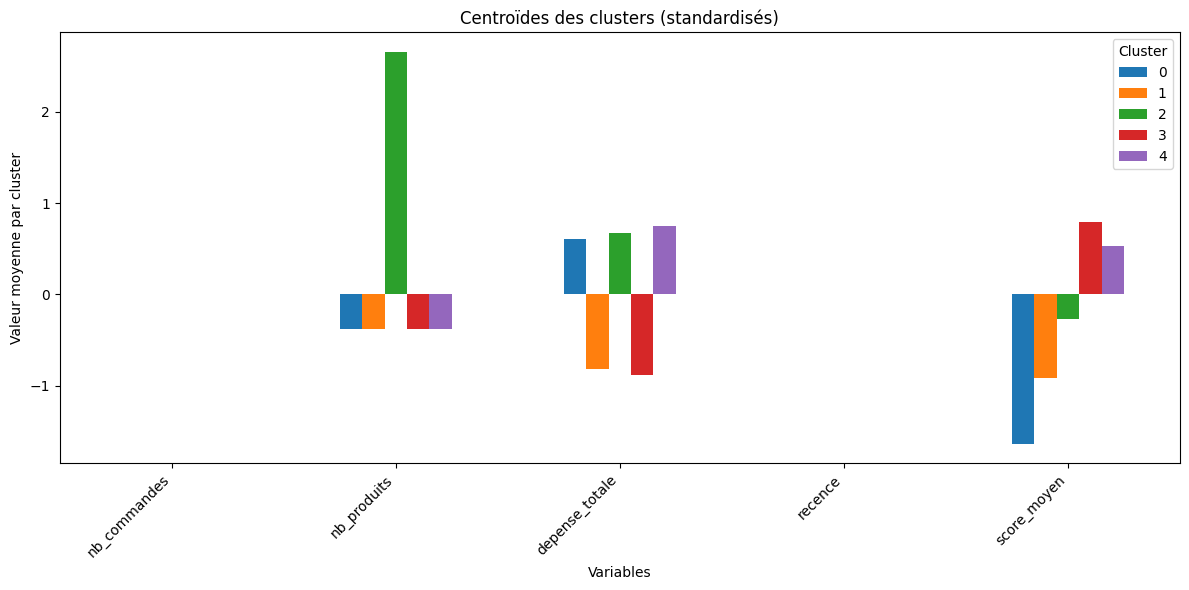

In [ ]:
# Centroïdes (dans l'espace standardisé si KMeans a été fait sur les données standardisées)
centroids = pd.DataFrame(final_kmeans.cluster_centers_, columns=data_chosen.columns)

# Barplot par cluster
centroids.T.plot(kind="bar", figsize=(12, 6))
plt.title("Centroïdes des clusters (standardisés)")
plt.ylabel("Valeur moyenne par cluster")
plt.xlabel("Variables")
plt.xticks(rotation=45, ha='right') 
plt.legend(title="Cluster")
plt.tight_layout()
plt.show()


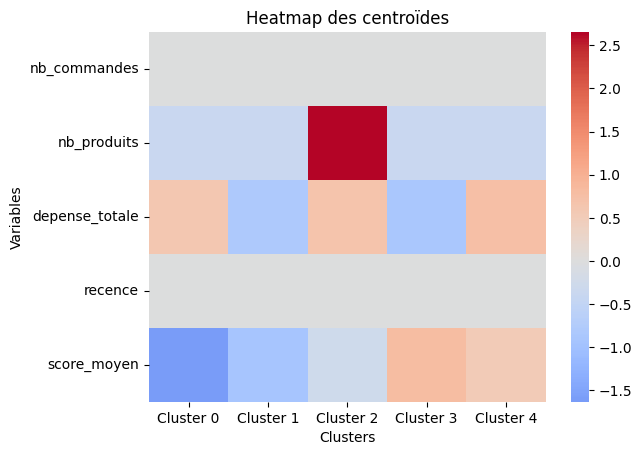

In [ ]:
sns.heatmap(centroids.T, annot=False, cmap="coolwarm", center=0)
plt.title("Heatmap des centroïdes")
plt.ylabel("Variables")
plt.xlabel("Clusters")
plt.show()

## Visualiser le profil complet de chaque cluster sur un cercle

In [ ]:
def plot_radar(centroids_df, data_orig_df, labels):
    # Calcul des moyennes originales par cluster
    original_means = data_orig_df.copy()
    original_means["cluster"] = labels
    original_means = original_means.groupby("cluster").median()

    categories = centroids_df.columns.tolist()
    N = len(categories)
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]

    plt.figure(figsize=(8, 8))

    for idx, row in centroids_df.iterrows():
        values = row.tolist()
        values += values[:1]
        plt.polar(angles, values, label=f"Cluster {idx}")

        # Afficher les vraies moyennes en annotation
        for j, var in enumerate(categories):
            angle = angles[j]
            radius = row[var]
            orig_val = original_means.loc[idx, var]
            offset = 0.05 if radius >= 0 else -0.05
            plt.text(
                angle,
                radius + offset,
                f"{orig_val:.2f}",
                ha="center",
                va="center",
                fontsize=10,
                color="black",
            )

    plt.xticks(angles[:-1], categories, color="grey", size=12)
    plt.title("Radar des centroïdes (standardisés)")
    plt.legend(loc="upper right", bbox_to_anchor=(1.3, 1.1))
    plt.tight_layout()
    plt.show()


plot_radar(centroids_df=centroids, data_orig_df=data_chosen, labels=final_clusters)


NameError: name 'centroids' is not defined

Sans fav produit : 

- Cluster 0 : clients satisfaits, qui achètent peu mais des produits chers
- Cluster 1 : dépensiers moyens mais particulièrement insatisfaits
- Cluster 2 : parmi les plus dépensiers, qui achètent beaucoup de produits pas chers. Leur satisfaction est plutot moyenne
- Cluster 3 : clients économes et satisfaits

## Comparer la distribution de chaque variable selon le cluster

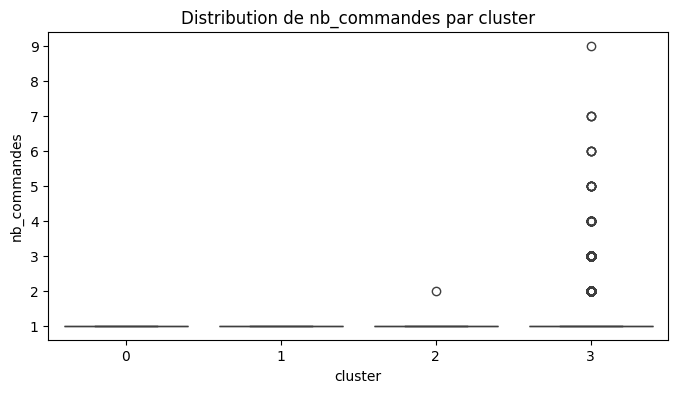

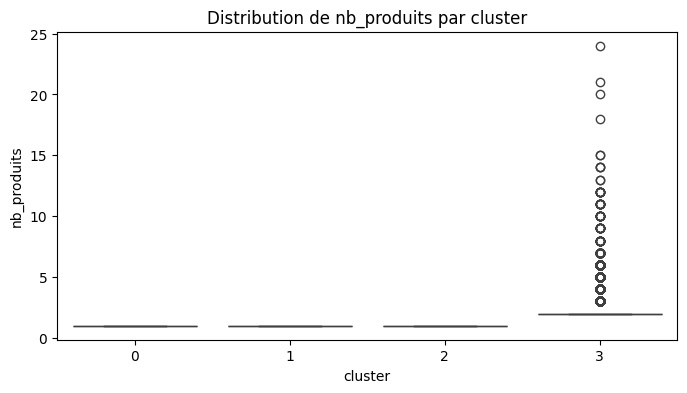

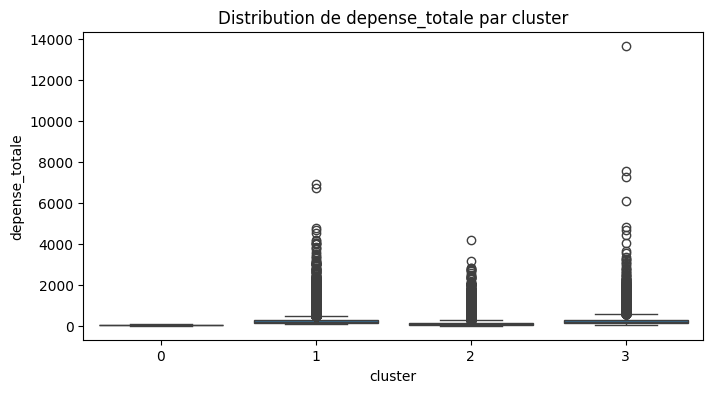

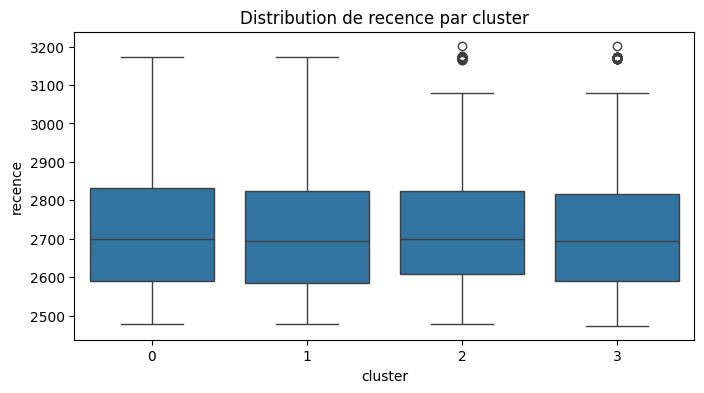

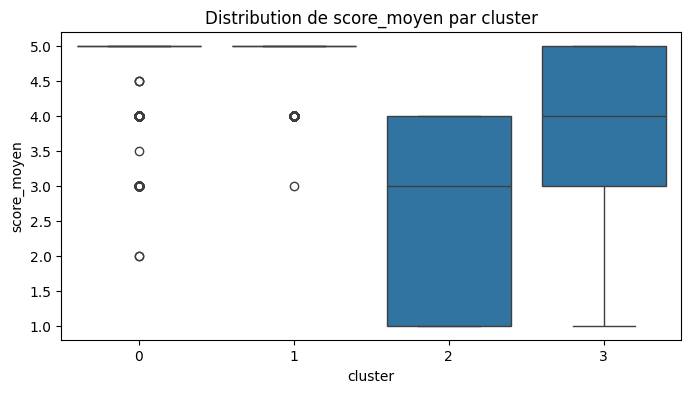

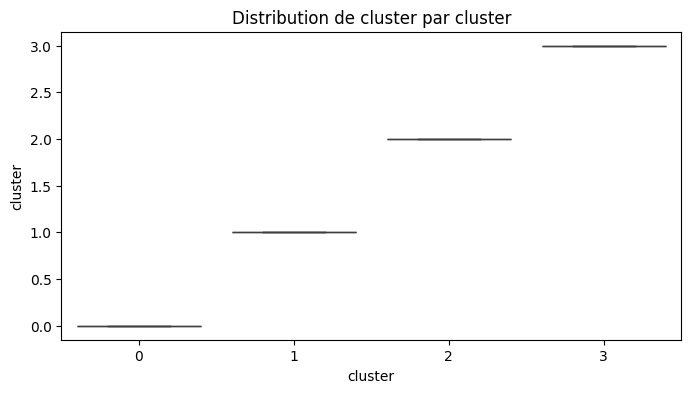

In [ ]:
data_chosen["cluster"] = final_kmeans.labels_

# Pour chaque variable quantitative
for col in data_chosen.columns:
    plt.figure(figsize=(8, 4))
    sns.boxplot(x="cluster", y=col, data=data_chosen)
    plt.title(f"Distribution de {col} par cluster")
    plt.show()


## Visualiser les clusters en 2D grâce à une ACP

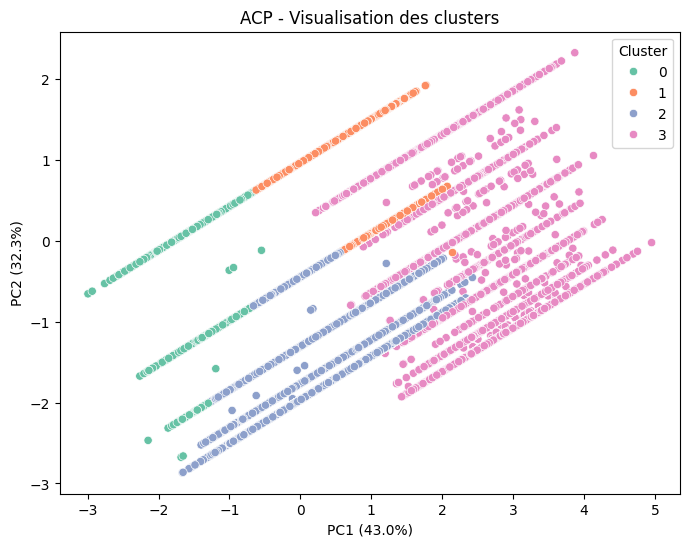

In [ ]:
pca = PCA(n_components=2)
components = pca.fit_transform(X_transformed)
pca_df = pd.DataFrame(components, columns=["PC1", "PC2"])
pca_df["cluster"] = final_kmeans.labels_

plt.figure(figsize=(8, 6))
sns.scatterplot(data=pca_df, x="PC1", y="PC2", hue="cluster", palette="Set2")
plt.title("ACP - Visualisation des clusters")
plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0] * 100:.1f}%)")
plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1] * 100:.1f}%)")
plt.legend(title="Cluster")
plt.show()


# DBSCAN 

Distance (rayon cercle) + nb voisins : si suffisamment de voisins --> clusters. Il fait ça pour chaque element. Le nb de clusters émerge naturellement. Cluster -1 = cluster des gens sans clusters. Essayer de minimiser le % de gens dans le cluster -1 et ne pas avoir un trop grand nombre de clusters.DBscan n'essaye pas de minimiser les métriques utilisées précédemment donc on ne peut pas comparer avec kmeans sur cette base. Existe-t-il une métrique spécifique de DBSCAN?

D'après [cette source](https://stackoverflow.com/questions/15050389/estimating-choosing-optimal-hyperparameters-for-dbscan/15063143#15063143), la valeur obtimale de min_samples est 2xnb_features i.e. 10 ici et la valeur obtimale de eps est définie par un coude dans la courbe du classement croissant des distances des K plus proches voisins (K = 2xnb_features-1 = 9) : les distances augmentent d'un coup pour les points correspondant à du bruit. Le code ci-dessous permet de tracer cette courbe et de définir eps : 

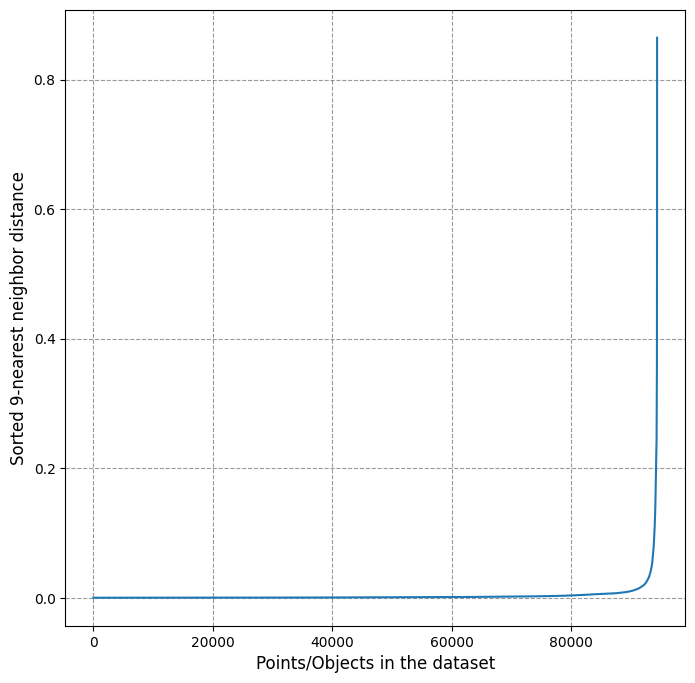

In [ ]:
def get_kdist_plot(X=None, k=None, radius_nbrs=1.0):
    nbrs = NearestNeighbors(n_neighbors=k, radius=radius_nbrs).fit(X)

    # For each point, compute distances to its k-nearest neighbors
    distances, indices = nbrs.kneighbors(X)

    distances = np.sort(distances, axis=0)
    distances = distances[:, k - 1]

    # Plot the sorted K-nearest neighbor distance for each point in the dataset
    plt.figure(figsize=(8, 8))
    plt.plot(distances)
    plt.xlabel("Points/Objects in the dataset", fontsize=12)
    plt.ylabel("Sorted {}-nearest neighbor distance".format(k), fontsize=12)
    plt.grid(True, linestyle="--", color="black", alpha=0.4)
    plt.show()
    plt.close()


k = 2 * X_transformed.shape[-1] - 1  # k=2*{dim(dataset)} - 1
get_kdist_plot(X=X_transformed, k=k)

D'après cette courbe, il semble que la valeur optimale de eps est 0.005 mais avec cette valeur on obtient 359 clusters. Autant de clusters empêche l'interprétation des résultats. On garde donc la valeur par défaut (0.5) qui donne 4 clusters : 

In [ ]:
# X_sample = X_transformed[np.random.choice(X_transformed.shape[0], 5000, replace=False), :]
clustering = DBSCAN(
    eps=0.5, min_samples=10, metric="euclidean", algorithm="ball_tree"
).fit(X_transformed)
clusters = clustering.labels_
print(len(set(clusters)))

4


In [ ]:
X_clustered = np.concatenate((X_transformed, np.array([clusters]).T), axis=1)

In [ ]:
# Taux d'outliers
mask = clusters == -1
percent_outliers = np.round(len(X_transformed[mask]) / len(X_transformed) * 100, 4)
print(f"Il y a {percent_outliers}% d'outliers")

# Enlever les points marqués comme bruit (label = -1)
mask = clusters != -1
X_WO_outliers = X_transformed[mask]
labels_WO_outliers = clusters[mask]

# Score spécifique auxalgorithmes de densité
validity = validity_index(X_WO_outliers, labels_WO_outliers, metric="euclidean")
print(f"Density-based cluster validity : {validity}")

# Moyennes par cluster
unique_labels = np.unique(labels_WO_outliers)
cluster_means = []

for label in unique_labels:
    cluster_points = X_WO_outliers[labels_WO_outliers == label]
    cluster_means.append(cluster_points.mean(axis=0))

cluster_means = np.array(cluster_means)

# Radar plot
num_vars = X_WO_outliers.shape[1]
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1]  # fermeture du polygone


# Plot
fig, ax = plt.subplots(figsize=(8, 6), subplot_kw=dict(polar=True))

for i, row in enumerate(cluster_means):
    row_closed = np.concatenate([row, [row[0]]])
    ax.plot(angles, row_closed, label=f"Cluster {unique_labels[i]}")
    ax.fill(angles, row_closed, alpha=0.2)

# Labels des axes
feature_labels = [f"{data_chosen.columns[i]}" for i in range(num_vars)]
angles_labels = angles[:-1]  # enlever l'angle du doublon
ax.set_xticks(angles_labels)
ax.set_xticklabels(feature_labels)

ax.set_title("Profil moyen par cluster (DBSCAN)", y=1.08)
ax.legend(loc="upper right", bbox_to_anchor=(1.2, 1.1))
plt.tight_layout()
plt.show()


Il y a 0.0043% d'outliers


In [ ]:
print(len(clusters))

# Clustering hiérarchique

peut créer des pb de mémoire RAM. K means grossier --> 1000 clusters = technique de réduction du nombre de lignes. Puis clustering hiérarchique sur ces clusters. Ensuite choisir le nb de cluster sur la base de silhouette et autre métriques utilisées sur k means.

In [ ]:
# kmeans préliminaire
preliminary_kmeans = KMeans(n_clusters=10_000, random_state=42)
preliminary_cluster_labels = preliminary_kmeans.fit_predict(X_transformed)

silhouette_avg = silhouette_score(X_transformed, preliminary_cluster_labels)
db_avg = davies_bouldin_score(X_transformed, preliminary_cluster_labels)
inertia = preliminary_kmeans.inertia_

print(
    f"Inertie : {inertia} \nSilhouette : {silhouette_avg} \nDavies Bouldin : {db_avg}"
)

In [ ]:
centroids = pd.DataFrame(
    preliminary_kmeans.cluster_centers_, columns=data_chosen.columns
)
Z = linkage(centroids, method="ward")

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(12, 8))

_ = dendrogram(Z, p=10, truncate_mode="lastp", ax=ax)

plt.title("Hierarchical Clustering Dendrogram")
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.ylabel("Distance.")
plt.show()

In [ ]:
for k in range(2, 11):
    labels = fcluster(Z, k, criterion="maxclust")
    silhouette_avg = silhouette_score(preliminary_kmeans, labels)
    db_avg = davies_bouldin_score(preliminary_kmeans, labels)
    print(f"Silhouette : {silhouette_avg} \nDavies Bouldin : {db_avg}")
    score = silhouette_score(X, labels)
    print(score)

Modifier le code ci dessus pour attribuer le cluster à chaque objet issu du kmeans. 
On peut aussi évaluer la cohérence de l'arbre pour choisir le nombre de clusters --> implémenté ici : https://docs.scipy.org/doc/scipy-1.15.2/reference/generated/scipy.cluster.hierarchy.inconsistent.html Il existe d'autres méthodes appropriées à l'arbre : https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.cut_tree.html

Critère de choix du modèle : l'interprétabilité et stabilité. 